## Carga y exploración inicial

In [23]:
import pandas as pd

file_path = 'data/Datos_proyecto.xlsx'

try:
    df = pd.read_excel(file_path)
    print("¡Archivo cargado exitosamente!")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'.")
    df = pd.DataFrame()


if not df.empty:
    
    # Vistazo a las primeras 5 filas
    print("\n--- Primeras 5 filas de los datos: ---")
    display(df.head())
    
    # Obtener un resumen del DataFrame.
    print("\n--- Información general del DataFrame: ---")
    df.info()
    
    # Contar cuántas filas hay para cada categoría (label).
    print("\n--- Distribución de las clases (labels): ---")
    print(df['labels'].value_counts())

¡Archivo cargado exitosamente!

--- Primeras 5 filas de los datos: ---


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



--- Información general del DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB

--- Distribución de las clases (labels): ---
labels
4    1025
3     894
1     505
Name: count, dtype: int64


No hay filas nulas, pero hay más labels de las categorías 4 y 3 que de 1, por lo que el modelo podría tender a predecir 4 o 3 simplemente porque aparece más veces.

C:\Users\juan_\AppData\Local\Temp\ipykernel_18788\1462879198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=df, palette='viridis')


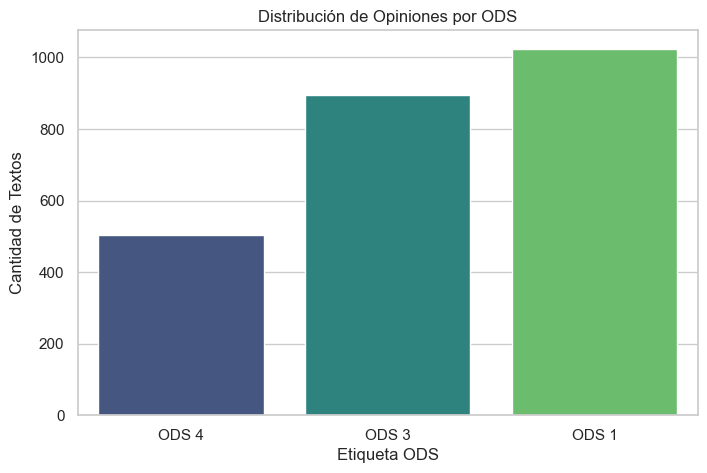

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(x='labels', data=df, palette='viridis')
plt.title('Distribución de Opiniones por ODS')
plt.xlabel('Etiqueta ODS')
plt.ylabel('Cantidad de Textos')
plt.xticks(ticks=[0, 1, 2], labels=['ODS 4', 'ODS 3', 'ODS 1'])
plt.show()

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juan_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juan_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
!pip install spacy==3.7.0
!pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl


  Using cached spacy-3.7.0.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [113 lines of output]
  Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
    Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
    Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
    Using cached cymem-2.0.11-cp313-cp313-win_amd64.whl.metadata (8.8 kB)
    Using cached preshed-3.0.10-cp313-cp313-win_amd64.whl.metadata (2.5 kB)
    Using cached murmurhash-1.0.13-cp313-cp313-win_amd64.whl.metadata (2.2 kB)
    Using cached thinc-8.2.5.tar.gz (193 kB)
    Installing build dependencies: started
    Installing build dependencies: finished with status 'error'
    error: subprocess-exited-with-error
  
    pip subprocess to install build dependencies did not run successfully.
    exit code: 1
  
    [81 lines of output]
    Ignoring numpy: markers 'python_version < "3.9"' don't match your environme

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.9 MB 11.8 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.9 MB 11.9 MB/s eta 0:00:01
     ------------------ --------------------- 6.0/12.9 MB 11.8 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.9 MB 11.8 MB/s eta 0:00:01
     -------------------------------- ------ 10.7/12.9 MB 11.8 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 11.5 MB/s  0:00:01
  Using cached spacy-3.7.5.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [113 lines of output]
  Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
    Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
    Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
    Using cached cymem-2.0.11-cp313-cp313-win_amd64.whl.metadata (8.8 kB)
    Using cached preshed-3.0.10-cp313-cp313-win_amd64.whl.metadata (2.5 kB)
    Using cached murmurhash-1.0.13-cp313-cp313-win_amd64.whl.metadata (2.2 kB)
    Using cached thinc-8.2.5.tar.gz (193 kB)
    Installing build dependencies: started
    Installing build dependencies: finished with status 'error'
    error: subprocess-exited-with-error
  
    pip subprocess to install build dependencies did not run successfully.
    exit code: 1
  
    [81 lines of output]
    Ignoring numpy: markers 'python_version < "3.9"' don't match your environme

In [27]:
import re
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar signos de puntuación y números
    texto = re.sub(r'[^a-záéíóúñü]', ' ', texto)
    # Quitar espacios repetidos y al inicio/final
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    doc = nlp(texto)
    # Lematización + eliminación de stopwords + tokens vacíos o muy cortos
    tokens_limpios = [
        token.lemma_
        for token in doc
        if token.lemma_.strip()                       # no vacío/espacio
        and token.lemma_ not in stop_words            # no stopword
        and len(token.lemma_) > 2                     # más de 2 letras
    ]
    
    return " ".join(tokens_limpios), tokens_limpios

df[['texto_limpio', 'tokens']] = df['textos'].apply(lambda x: pd.Series(limpiar_texto(x)))

Se limita el vocabulario a las 3000 palabras más frecuentes y se convierte el texto a vectores usando Tf-Idf

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_ngram = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X = vectorizer_ngram.fit_transform(df['texto_limpio'])
y = df['labels']

print("Forma de la nueva matriz de características (X):", X.shape)

Forma de la nueva matriz de características (X): (2424, 5000)


Separar conjunto de entrenamiento y de prueba.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,   
    random_state=42,  
    stratify=y        
)

print("Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):")
print(y_train.value_counts())

Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):
labels
4    820
3    715
1    404
Name: count, dtype: int64


In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Aplicar SMOTE solo a los datos de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Forma de X_train antes de SMOTE:", X_train.shape)
print("Forma de X_train después de SMOTE:", X_train_smote.shape)

print(pd.Series(y_train_smote).value_counts())

Forma de X_train antes de SMOTE: (1939, 5000)
Forma de X_train después de SMOTE: (2460, 5000)
labels
3    820
1    820
4    820
Name: count, dtype: int64


Entrenar los 3 modelos. Se eligió:
- Regresión Logística
- Bayes Multinomial
- Support Vector Machine (SVC)

In [31]:
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd

# =============================================================================
# 1. BÚSQUEDA PARA REGRESIÓN LOGÍSTICA
# =============================================================================

pipeline_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

# 'classifier__C' se refiere al parámetro 'C' del paso 'classifier'
parameters_lr = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Mejor F1-score para LR: {grid_search_lr.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_lr.best_params_}\n")


# =============================================================================
# 2. BÚSQUEDA PARA NAIVE BAYES MULTINOMIAL
# =============================================================================
print("--- Iniciando GridSearchCV para Naive Bayes ---")

pipeline_nb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', MultinomialNB())
])

# Naive Bayes tiene un parámetro principal: 'alpha' (suavizado)
parameters_nb = {
    'classifier__alpha': [0.1, 0.5, 1.0]
}

grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train, y_train)

print(f"Mejor F1-score para NB: {grid_search_nb.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_nb.best_params_}\n")


# =============================================================================
# 3. BÚSQUEDA PARA SUPPORT VECTOR MACHINE (LINEAR SVC)
# =============================================================================
print("--- Iniciando GridSearchCV para SVM (LinearSVC) ---")

pipeline_svc = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42, max_iter=5000))
])

# El parámetro clave de LinearSVC es 'C' (penalización del error)
parameters_svc = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_svc = GridSearchCV(pipeline_svc, parameters_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

print(f"Mejor F1-score para SVM: {grid_search_svc.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_svc.best_params_}\n")


# Encontrar el mejor
scores = {
    'Logistic Regression': grid_search_lr.best_score_,
    'Naive Bayes': grid_search_nb.best_score_,
    'SVM (LinearSVC)': grid_search_svc.best_score_
}

# Encontrar el modelo con el mejor score
best_model_name = max(scores, key=scores.get)
print(f"El mejor modelo es: {best_model_name} con un F1-score de {scores[best_model_name]:.4f}")

# Guardar el mejor modelo para usarlo después
if best_model_name == 'Logistic Regression':
    best_model = grid_search_lr.best_estimator_
elif best_model_name == 'Naive Bayes':
    best_model = grid_search_nb.best_estimator_
else:
    best_model = grid_search_svc.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para LR: 0.9747
Mejores parámetros: {'classifier__C': 1}

--- Iniciando GridSearchCV para Naive Bayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor F1-score para NB: 0.9692
Mejores parámetros: {'classifier__alpha': 0.5}

--- Iniciando GridSearchCV para SVM (LinearSVC) ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para SVM: 0.9742
Mejores parámetros: {'classifier__C': 0.1}

El mejor modelo es: Logistic Regression con un F1-score de 0.9747


  Resultados Finales: Regresión Logística
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.94      0.95       101
    ODS 3 (Salud)       0.97      0.98      0.97       179
ODS 4 (Educación)       0.98      0.98      0.98       205

         accuracy                           0.97       485
        macro avg       0.97      0.97      0.97       485
     weighted avg       0.97      0.97      0.97       485



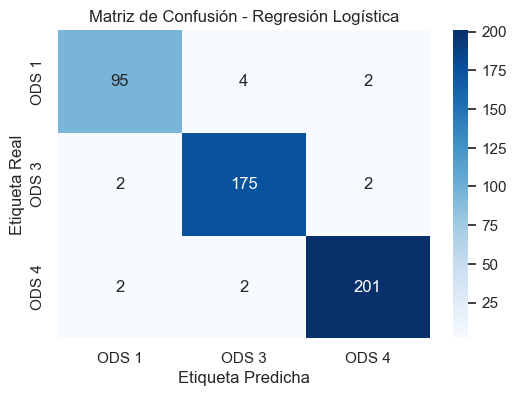


    Resultados Finales: Naive Bayes
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.91      0.97      0.94       101
    ODS 3 (Salud)       0.96      0.95      0.96       179
ODS 4 (Educación)       0.97      0.95      0.96       205

         accuracy                           0.95       485
        macro avg       0.95      0.96      0.95       485
     weighted avg       0.96      0.95      0.95       485



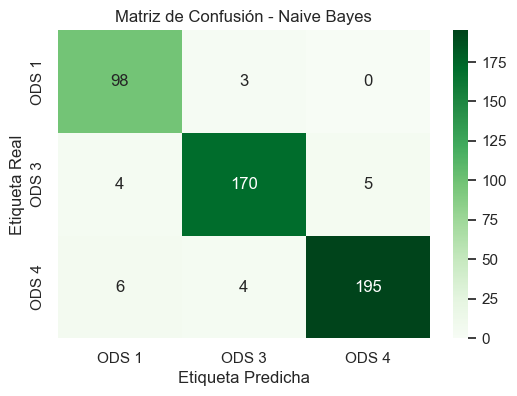


     Resultados Finales: SVM (LinearSVC)
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.96      0.96       101
    ODS 3 (Salud)       0.98      0.97      0.97       179
ODS 4 (Educación)       0.97      0.98      0.98       205

         accuracy                           0.97       485
        macro avg       0.97      0.97      0.97       485
     weighted avg       0.97      0.97      0.97       485



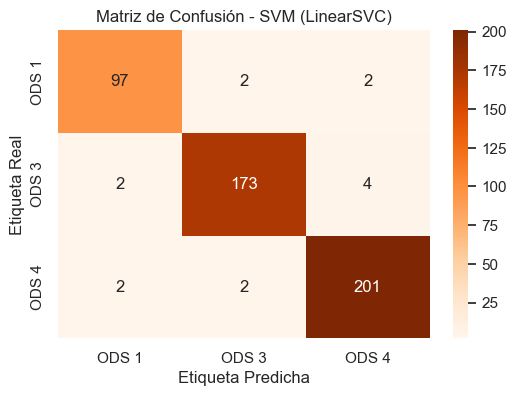

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_lr_model = grid_search_lr.best_estimator_
best_nb_model = grid_search_nb.best_estimator_
best_svc_model = grid_search_svc.best_estimator_


# --- 1. Evaluación de Regresión Logística ---
print("="*40)
print("  Resultados Finales: Regresión Logística")
print("="*40)
y_pred_lr = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 2. Evaluación de Naive Bayes ---
print("\n" + "="*40)
print("    Resultados Finales: Naive Bayes")
print("="*40)
y_pred_nb = best_nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Naive Bayes')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 3. Evaluación de SVM (LinearSVC) ---
print("\n" + "="*40)
print("     Resultados Finales: SVM (LinearSVC)")
print("="*40)
y_pred_svc = best_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - SVM (LinearSVC)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

In [33]:
import pandas as pd

final_predictions = best_model.predict(X_test)

df_resultados = pd.DataFrame({
    'textos': df.loc[y_test.index, 'textos'],
    'labels_reales': y_test,
    'labels_predichas': final_predictions
})

output_filename = 'data/predicciones_grupo_16.xlsx'
df_resultados.to_excel(output_filename, index=False)

display(df_resultados.head())

,textos,labels_reales,labels_predichas
102,La relación entre el estatus étnico y el consu...,3,3
1220,"En los países de la OCDE, por cada reducción d...",3,3
233,Una segunda etapa de seguimiento ocurre a los ...,4,4
2056,La persona respetable más pobre de cualquier s...,1,1
698,En ellos se basan las publicaciones anuales co...,4,4


In [34]:
def mostrar_palabras_clave(model_pipeline, vectorizer, top_n=20):
    classifier = model_pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    
    # Coeficientes por palabra
    coefs_por_clase = classifier.coef_
    
    # Palabras más importantes para cada clase
    for i, class_label in enumerate(classifier.classes_):
        coefs = coefs_por_clase[i]
        top_coef_indices = coefs.argsort()[-top_n:]
        
        top_words = [feature_names[j] for j in top_coef_indices]
        
        print(f"--- ODS {class_label} ---")
        print(", ".join(reversed(top_words)))
        print("")


print("Palabras más influyentes por ODS:")
mostrar_palabras_clave(best_model, vectorizer_ngram)

Palabras más influyentes por ODS:
--- ODS 1 ---
pobreza, pobre, hogar, ingreso, social, privación, protección social, protección, empleo, crecimiento, niño, transferencia, umbral, vivir, familia, multidimensional, urbano, pobreza infantil, trabajo, vivienda

--- ODS 3 ---
salud, atención, médico, enfermedad, paciente, sanitario, mental, mortalidad, tratamiento, alcohol, hospital, droga, servicio, medicamento, consumo, atención primario, salud mental, hospitalario, clínico, muerte

--- ODS 4 ---
educación, escuela, estudiante, educativo, docente, aprendizaje, escolar, alumno, profesor, habilidad, enseñanza, evaluación, maestro, formación, superior, universidad, sistema educativo, personal, profesional, pisa



# Clasificacion datos de prueba

Empezaremos limpiando los textos entregados, luego de esto vamos a clasficar estos textos usando el modelo LinearSVC, y por ultimo, agregaremos al documento de excel una columna con la clasificacion dada a cada texto.

In [ ]:
df_prueba = pd.read_excel('data/Datos de prueba_proyecto.xlsx')
df_prueba['texto_limpio'] = df_prueba['Textos_espanol'].apply(lambda x: limpiar_texto(x)[0])
X_prueba = vectorizer_ngram.transform(df_prueba['texto_limpio'])
df_prueba['label'] = best_model.predict(X_prueba)
df_prueba.drop(columns=['texto_limpio'], inplace=True)
output_filename = 'data/predicciones_definitivas_grupo_16.xlsx'
df_prueba.to_excel(output_filename, index=False)

df_prueba.head()



,Textos_espanol,texto_limpio,label
0,"El rector, que es el representante local del M...",rector ser representante local ministerio educ...,4
1,Tenga en cuenta que todos los programas antipo...,tener cuenta programa antipobrezar tener condi...,4
2,"Debido a que son en gran medida invisibles, es...",debido ser gran medida invisible forma trabajo...,1
3,Los recursos aún son limitados en este sector....,recurso aún ser limitar sector servicio privad...,3
4,"Durante el período 1985-2008, la educación pri...",período educación primario secundario terciari...,4
